In [128]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pprint
import warnings
warnings.filterwarnings('ignore')

In [129]:
# Load the dataset

df = pd.read_csv('logisticRegressionDataset.csv')

In [130]:
# Display the first few rows of the dataset

df.head()

,Age,Monthly_Spend,Session_Duration_Minutes,Region,Subscription
0,45,120.50,65,North,Yes
1,32,55.20,30,South,No
2,58,180.75,95,East,Yes
3,25,45.00,15,West,No
4,60,195.00,110,North,Yes


In [131]:
# Get a summary of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       228 non-null    int64  
 1   Monthly_Spend             228 non-null    float64
 2   Session_Duration_Minutes  228 non-null    int64  
 3   Region                    228 non-null    object 
 4   Subscription              228 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 9.0+ KB


In [132]:
# Get statistical summary of the dataset

df.describe()

,Age,Monthly_Spend,Session_Duration_Minutes
count,228.000000,228.000000,228.000000
mean,43.039474,116.912281,61.026316
std,12.104291,50.549801,30.143113
min,22.000000,35.000000,10.000000
25%,32.000000,69.000000,34.000000
50%,41.500000,104.500000,57.000000
75%,53.000000,160.250000,86.250000
max,62.000000,200.000000,114.000000


In [133]:
# Check for missing values

df.isnull().sum()

Age                         0
Monthly_Spend               0
Session_Duration_Minutes    0
Region                      0
Subscription                0
dtype: int64

In [134]:
# Check data types of each column

df.dtypes

Age                           int64
Monthly_Spend               float64
Session_Duration_Minutes      int64
Region                       object
Subscription                 object
dtype: object

In [135]:
# Encode target variable (Yes=1, No=0)
df["Subscription"] = df["Subscription"].map({"Yes": 1, "No": 0})


In [136]:
# One-hot encode the Region column
df = pd.get_dummies(df, columns=["Region"], drop_first=True)

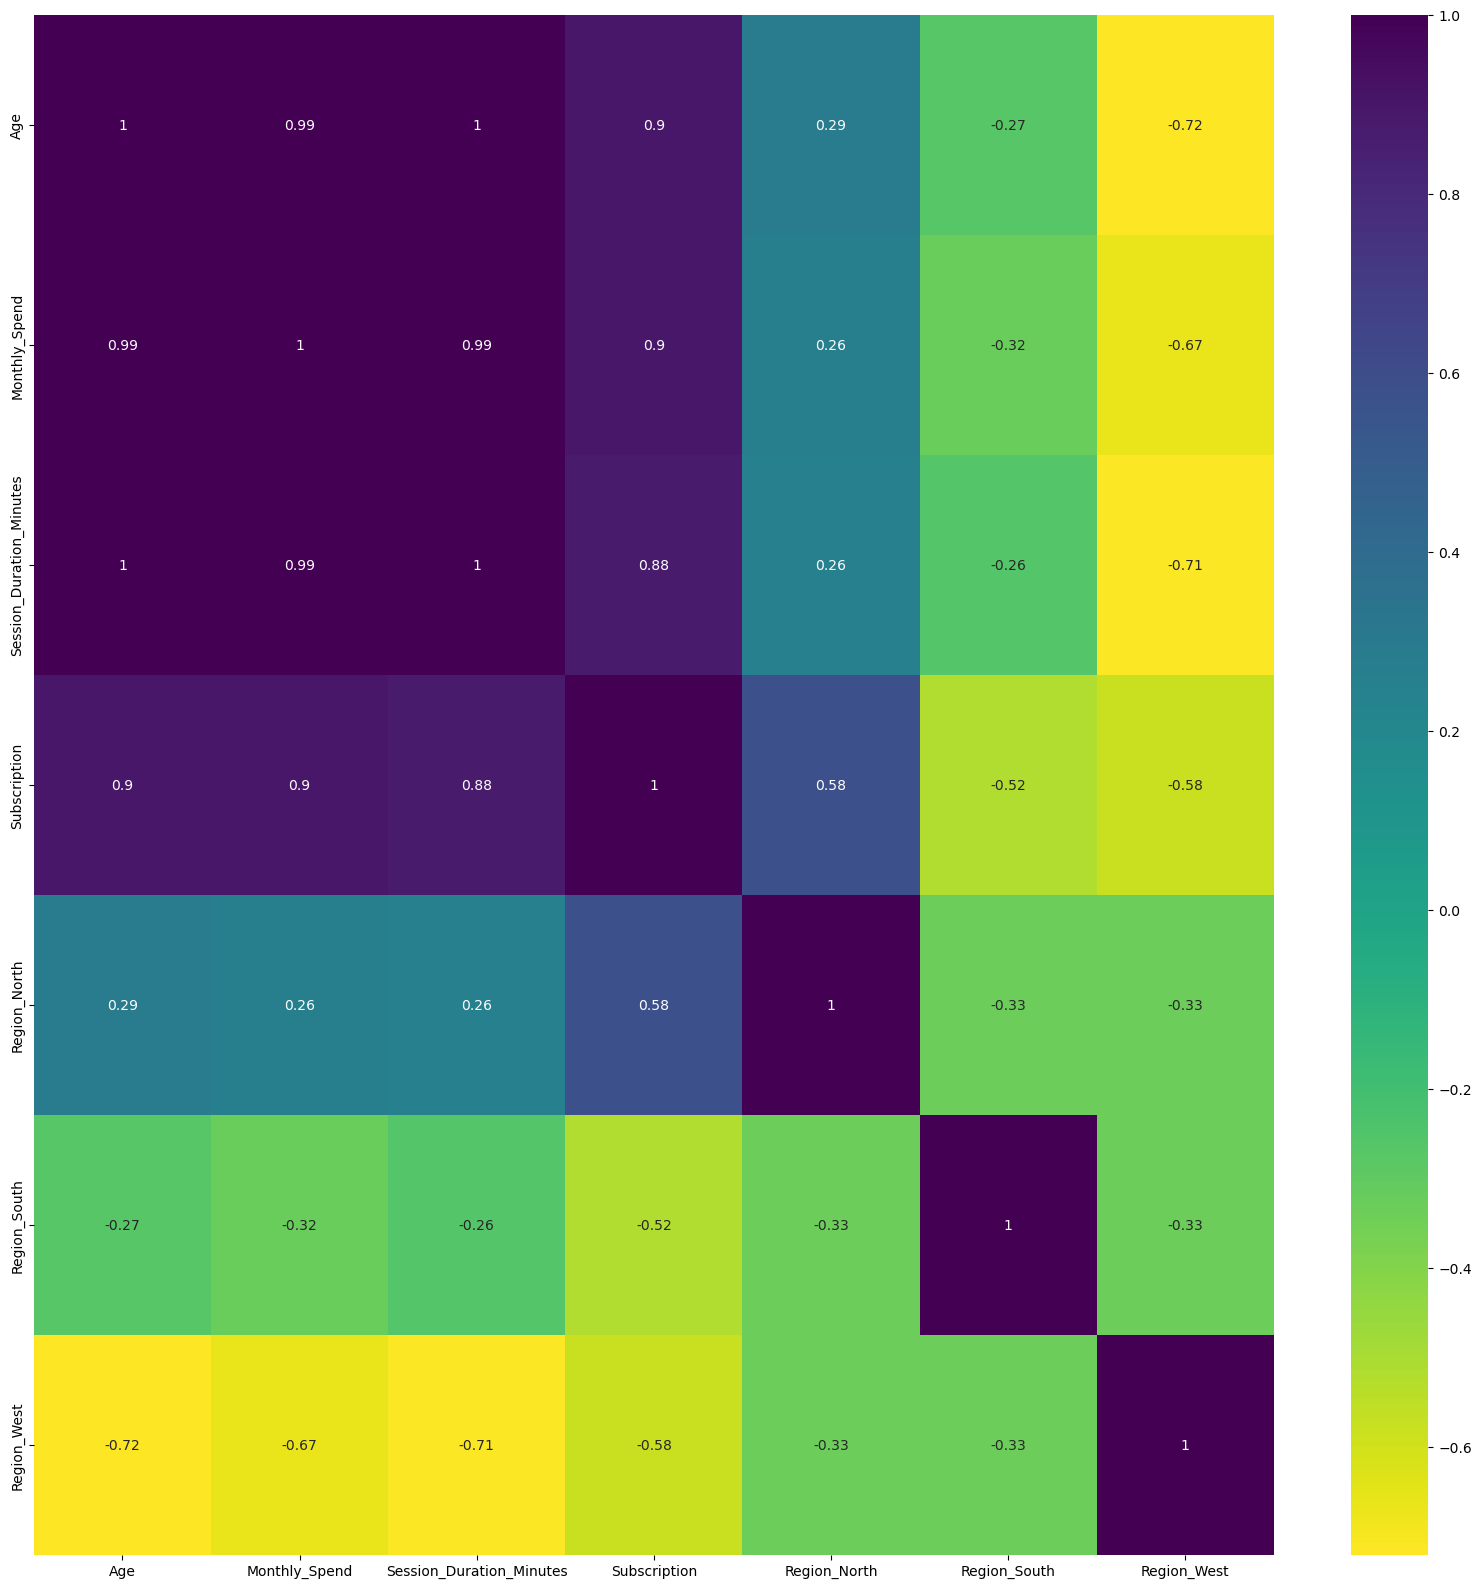

In [137]:
corr = df.corr()  # Compute correlation matrix
plt.figure(figsize = (20,20))

# heatmap 
sns.heatmap(corr , cmap='viridis_r' , annot=True)

plt.show()

Feature Selection

In [138]:

cor_target = abs(corr['Subscription'])  # Absolute correlation with target variable

relevant_features = cor_target[cor_target > 0.25]

names = [index for index, value in relevant_features.items()]

# Drop the target variable from the results
names.remove("Subscription")

pprint.pprint(names)

['Age',
 'Monthly_Spend',
 'Session_Duration_Minutes',
 'Region_North',
 'Region_South',
 'Region_West']


Scaling

Split features and target

In [139]:
X = df.drop("Subscription", axis=1) # all columns except Subscription
y = df["Subscription"] # only Subscription column

Train-test split

In [140]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42, stratify = y
)

Scale Features

In [141]:
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create and train logistic regression model

In [142]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

Make predictions

In [143]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

In [144]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

# Balanced accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)

# Precision and Recall
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

In [145]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", bal_acc)
print("Precision:", prec)
print("Recall:", rec)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Balanced Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        28

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



Confusion Matrix:
 [[29  0]
 [ 0 28]]


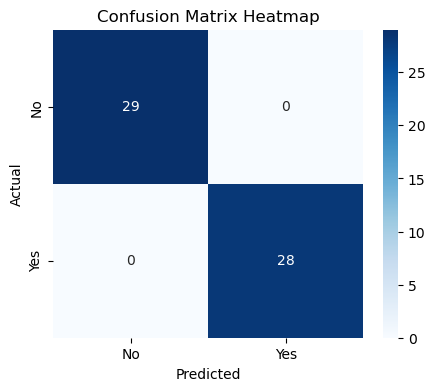

In [146]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

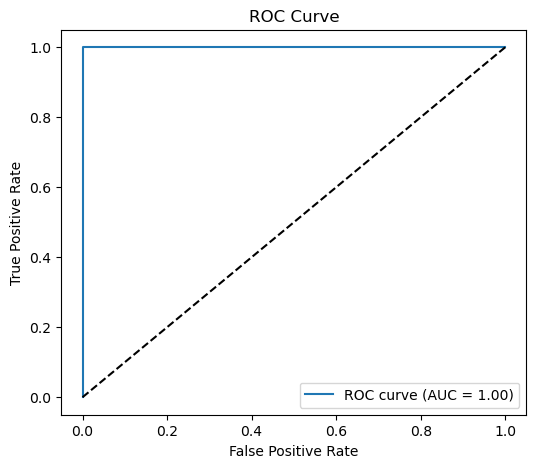

In [147]:
from sklearn.metrics import roc_auc_score, roc_curve


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0,1], [0,1], "k--")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [148]:
# Check learned coefficients
coeff_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nModel Coefficients:\n", coeff_df)


Model Coefficients:
                     Feature  Coefficient
0                       Age     1.449336
1             Monthly_Spend     1.384504
2  Session_Duration_Minutes     1.311557
3              Region_North     1.256915
5               Region_West    -0.347015
4              Region_South    -0.811582
